# BundleFlow Colab Demo

**🎯 Rectified Flow–based menus for combinatorial auctions**

このノートブックでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化をデモンストレーションします。

## 📋 目次
1. [環境セットアップ](#setup)
2. [新しいAPI構造のデモ](#api-demo)
3. [Stage1: Flow初期化](#stage1)
4. [Stage2: Menu最適化](#stage2)
5. [結果の可視化](#visualization)

---


## 1. 環境セットアップ

まず、GPU環境を確認し、必要なパッケージをインストールします。


In [ ]:
# GPU環境確認
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# 必要なパッケージのインストール
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install omegaconf tqdm numpy matplotlib seaborn


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# PyTorchとCUDAの確認
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0
CUDA available: False


## 2. 新しいAPI構造のデモ

BundleFlowの新しいAPI構造を紹介します。


In [4]:
# 新しいAPI構造のインポート
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BundleFlowの新しいAPI
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, Mechanism
from bundleflow.valuation.valuation import XORValuation

print("✅ 新しいAPI構造のインポートが完了しました")
print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


✅ 新しいAPI構造のインポートが完了しました
PyTorch device: cpu


In [5]:
# 基本的なAPIのデモンストレーション
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. BundleFlow（速度場ネットワーク）の作成
m = 10  # 商品数
flow = BundleFlow(m=m).to(device)
print(f"✅ BundleFlow created with m={m}")

# 2. 速度場の計算
x = torch.randn(3, m, device=device)
t = torch.rand(3, device=device)
v = flow.velocity(x, t)
print(f"✅ Velocity field shape: {v.shape}")

# 3. MenuElement（メニュー要素）の作成
D = 5  # 初期分布の混合成分数
elem = MenuElement(m=m, D=D).to(device)
price = elem.price()
print(f"✅ MenuElement created with price: {price.detach().item():.4f}")

# 4. XORValuation（評価関数）の作成
atoms = [([1, 2, 3], 5.0), ([4, 5], 3.0), ([6, 7, 8, 9], 8.0)]
valuation = XORValuation.from_bundle_list(m, atoms)
bundle = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0])
value = valuation.value(bundle)
print(f"✅ XORValuation value: {value:.4f}")


Using device: cpu
✅ BundleFlow created with m=10
✅ Velocity field shape: torch.Size([3, 10])
✅ MenuElement created with price: 0.1578
✅ XORValuation value: 8.0000


## 3. Stage1: Flow初期化

速度場ネットワークを学習して、連続変数から離散束への変換を学習します。


In [6]:
# Stage1の設定（小規模でデモ用）
stage1_config = {
    'm': 8,           # 商品数（小規模）
    'D': 4,           # 混合成分数
    'iters': 1000,    # イテレーション数（デモ用に短縮）
    'batch': 256,     # バッチサイズ
    'lr': 5e-3,       # 学習率
    'sigma_z': 0.05,  # ノイズ標準偏差
    'ode_steps': 25,  # ODE積分ステップ数
    'seed': 42
}

print("Stage1設定:")
for key, value in stage1_config.items():
    print(f"  {key}: {value}")


Stage1設定:
  m: 8
  D: 4
  iters: 1000
  batch: 256
  lr: 0.005
  sigma_z: 0.05
  ode_steps: 25
  seed: 42


In [7]:
# Stage1学習の実行
import random
import time
from torch import optim

# 乱数固定
random.seed(stage1_config['seed'])
torch.manual_seed(stage1_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage1_config['seed'])

# フローモデルの作成
flow = BundleFlow(m=stage1_config['m']).to(device)
optimizer = optim.Adam(flow.parameters(), lr=stage1_config['lr'])

# 初期分布（混合Gaussian）
mus = torch.empty(stage1_config['D'], stage1_config['m'], device=device).uniform_(-0.2, 1.2)
sigmas = torch.full((stage1_config['D'],), 0.5, device=device)
weights = torch.full((stage1_config['D'],), 1.0 / stage1_config['D'], device=device)

print(f"🚀 Stage1学習開始 (device: {device})")
print(f"モデルパラメータ数: {sum(p.numel() for p in flow.parameters()):,}")

# 学習ループ
losses = []
start_time = time.time()

for it in range(1, stage1_config['iters'] + 1):
    # Rectified Flow損失の計算
    loss = flow.rectified_flow_loss(
        B=stage1_config['batch'],
        mus=mus, sigmas=sigmas, weights=weights,
        sigma_z=stage1_config['sigma_z']
    )
    
    # 最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach().item())
    
    # 進捗表示
    if it % 100 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage1_config['iters']}] Loss: {loss.detach().item():.6f} Time: {elapsed:.1f}s")

print(f"✅ Stage1学習完了! 最終損失: {losses[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")


🚀 Stage1学習開始 (device: cpu)
モデルパラメータ数: 46,785
[100/1000] Loss: 1.100278 Time: 0.2s
[200/1000] Loss: 0.998842 Time: 0.4s
[300/1000] Loss: 1.078811 Time: 0.5s
[400/1000] Loss: 0.993962 Time: 0.7s
[500/1000] Loss: 1.000068 Time: 0.8s
[600/1000] Loss: 1.063291 Time: 1.0s
[700/1000] Loss: 1.018739 Time: 1.1s
[800/1000] Loss: 1.024564 Time: 1.3s
[900/1000] Loss: 1.049826 Time: 1.4s
[1000/1000] Loss: 1.014985 Time: 1.6s
✅ Stage1学習完了! 最終損失: 1.014985
総学習時間: 1.6秒


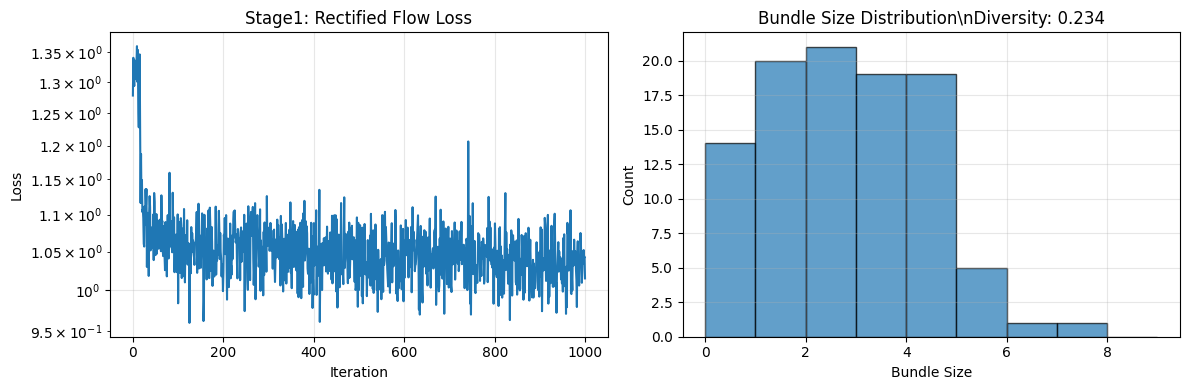

生成された束の多様性: 0.234 (60/256 ユニークな束)


In [8]:
# Stage1の結果可視化
plt.figure(figsize=(12, 4))

# 損失の推移
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Stage1: Rectified Flow Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 束生成のテスト
plt.subplot(1, 2, 2)
with torch.no_grad():
    # ランダムな初期値から束を生成
    z = torch.randn(100, stage1_config['m'], device=device)
    t_grid = torch.linspace(0.0, 1.0, steps=stage1_config['ode_steps'], device=device)
    x_T = flow.flow_forward(z, t_grid)
    bundles = flow.round_to_bundle(x_T)
    
    # 束の多様性を計算
    unique_bundles = torch.unique(bundles, dim=0)
    diversity = len(unique_bundles) / (2 ** stage1_config['m'])
    
    # 束の分布を可視化
    bundle_sizes = bundles.sum(dim=1).detach().cpu().numpy()
    plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
    plt.title(f'Bundle Size Distribution\\nDiversity: {diversity:.3f}')
    plt.xlabel('Bundle Size')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"生成された束の多様性: {diversity:.3f} ({len(unique_bundles)}/{2**stage1_config['m']} ユニークな束)")


## 4. Stage2: Menu最適化

学習済みの速度場を使用して、メニュー要素（価格と初期分布）を最適化します。


In [9]:
# Stage2の設定（小規模でデモ用）
stage2_config = {
    'K': 16,           # メニュー要素数（小規模）
    'D': 4,            # 初期分布の混合成分数
    'iters': 500,      # イテレーション数（デモ用に短縮）
    'batch': 64,       # バッチサイズ
    'lr': 3e-1,        # 学習率
    'lam_start': 1e-3, # SoftMax温度の開始値
    'lam_end': 0.1,    # SoftMax温度の終了値
    'ode_steps': 25,   # ODE積分ステップ数
    'n_val': 200,      # 評価関数の数（小規模）
    'a': 8,            # XOR原子数（小規模）
    'seed': 123
}

print("Stage2設定:")
for key, value in stage2_config.items():
    print(f"  {key}: {value}")


Stage2設定:
  K: 16
  D: 4
  iters: 500
  batch: 64
  lr: 0.3
  lam_start: 0.001
  lam_end: 0.1
  ode_steps: 25
  n_val: 200
  a: 8
  seed: 123


In [10]:
# 評価関数データの生成
from bundleflow.data import gen_uniform_iid_xor

# 乱数固定
random.seed(stage2_config['seed'])
torch.manual_seed(stage2_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage2_config['seed'])

# 合成XOR評価関数を生成
valuations = []
for i in range(stage2_config['n_val']):
    val = gen_uniform_iid_xor(
        m=stage1_config['m'],
        a=stage2_config['a'],
        low=0.0,
        high=1.0,
        seed=1337 + i,
        atom_size_mode='small'
    )
    valuations.append(val)

print(f"✅ {len(valuations)}個の評価関数を生成しました")
print(f"最初の評価関数の原子数: {len(valuations[0].atoms)}")

# 評価関数の統計
atom_counts = [len(v.atoms) for v in valuations]
print(f"原子数の統計: min={min(atom_counts)}, max={max(atom_counts)}, mean={np.mean(atom_counts):.1f}")


✅ 200個の評価関数を生成しました
最初の評価関数の原子数: 8
原子数の統計: min=8, max=8, mean=8.0


In [ ]:
# === GPU監視ヘルパー関数 ============================================
import inspect

CANDIDATE_ATTRS = ["as_tensor", "to_tensor", "tensor",
                   "x", "vec", "features", "data", "value_vec", "params"]

def extract_feature_like(v):
    """
    Valuationオブジェクト v から "特徴ベクトル" を取り出す。
    - 無引数メソッド(as_tensor/to_tensor 等)は呼ぶ。
    - 引数が必要なメソッド(value(s_bool) 等)はスキップ。
    - 代表的な属性名を順に探す。
    - XORValuationの場合はatomsから特徴ベクトルを構築。
    """
    # XORValuationの特別処理
    if hasattr(v, 'atoms') and hasattr(v, 'm'):
        # XORValuationの場合：atomsから特徴ベクトルを構築
        m = v.m
        feature_vec = torch.zeros(m, dtype=torch.float32)
        
        # 各atomの価格を対応する商品位置に加算
        for mask, price in v.atoms:
            for i in range(m):
                if mask & (1 << i):  # ビットiが立っている場合
                    feature_vec[i] += price
        
        return feature_vec
    
    # 無引数メソッド候補
    for name in ["as_tensor", "to_tensor"]:
        if hasattr(v, name) and callable(getattr(v, name)):
            fn = getattr(v, name)
            try:
                sig = inspect.signature(fn)
                if len([p for p in sig.parameters.values()
                        if p.default is p.empty and p.kind in (p.POSITIONAL_ONLY, p.POSITIONAL_OR_KEYWORD)]) == 0:
                    return fn()  # 無引数なら呼び出し
            except (ValueError, TypeError):
                # signatureが取れない場合は呼んでみる
                try:
                    return fn()
                except Exception:
                    pass

    # 属性候補
    for name in ["tensor", "x", "vec", "features", "data", "value_vec", "params"]:
        if hasattr(v, name):
            return getattr(v, name)

    # デバッグ用の情報を投げる
    public = [a for a in dir(v) if not a.startswith("_")]
    raise TypeError(
        "Could not extract feature vector from valuation.\n"
        f"type={type(v)}\n"
        f"public={public}\n"
        "→ v.x / v.vec / v.features 等の属性名をCANDIDATE_ATTRSへ追加すること。"
    )

def to_tensor_1d(x, device):
    if torch.is_tensor(x):
        t = x
    elif isinstance(x, (list, tuple)):
        t = torch.tensor(x)
    elif isinstance(x, (int, float)):
        t = torch.tensor([x])
    else:
        try:
            t = torch.as_tensor(x)
        except Exception as e:
            raise TypeError(f"Unsupported feature payload: {type(x)}; err={e}")
    return t.to(device=device, dtype=torch.float32, non_blocking=True).flatten()

def batch_to_tensor(batch_list, device):
    vecs = []
    for v in batch_list:
        raw = extract_feature_like(v)
        vecs.append(to_tensor_1d(raw, device))
    # 長さチェック
    dims = {t.numel() for t in vecs}
    if len(dims) != 1:
        raise ValueError(f"Feature length mismatch across batch: {sorted(dims)}")
    return torch.stack(vecs, dim=0)  # [B, D]

# === Stage2学習の実行（GPU監視付き） ============================
from bundleflow.models.menu import make_null_element, revenue_loss

# フローモデルを凍結（Stage1で学習済み）
for p in flow.parameters():
    p.requires_grad_(False)
flow.eval()

# メニュー要素の作成
menu = [MenuElement(m=stage1_config['m'], D=stage2_config['D']) for _ in range(stage2_config['K'])]
menu.append(make_null_element(stage1_config['m']))  # IR制約用のnull要素

# メニュー要素をデバイスに移動
for elem in menu:
    elem.to(device)

# オプティマイザー
all_params = []
for elem in menu:
    all_params.extend(elem.parameters())
optimizer = optim.Adam(all_params, lr=stage2_config['lr'])

print(f"🚀 Stage2学習開始 (device: {device})")
print(f"メニュー要素数: {len(menu)}")
print(f"学習パラメータ数: {sum(p.numel() for p in all_params):,}")

# GPU情報の表示
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Flow model device: {next(flow.parameters()).device}")
    print(f"Menu elements device: {next(menu[0].parameters()).device}")
else:
    print("⚠️  GPU not available, using CPU")

# 学習ループ（GPU監視付き）
revenues = []
start_time = time.time()

for it in range(1, stage2_config['iters'] + 1):
    # バッチデータの準備
    batch_size = min(stage2_config['batch'], len(valuations))
    batch_vals = random.sample(valuations, batch_size)
    
    # GPU監視用：特徴テンソルを作成（デバッグ用）
    x = batch_to_tensor(batch_vals, device)  # GPU上の特徴テンソルを作る
    
    # 温度スケジューリング
    lam = stage2_config['lam_start'] + (stage2_config['lam_end'] - stage2_config['lam_start']) * (it / stage2_config['iters'])
    
    # 時間グリッド
    t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)
    
    # 収益損失の計算（元のbatch_valsを使用）
    loss = revenue_loss(flow, batch_vals, menu, t_grid, lam=lam)
    
    # デバイス整合性チェック（最初のイテレーションのみ）
    if it == 1:
        print("🔍 Device consistency check:")
        print(f"  batch_vals length: {len(batch_vals)}")
        print(f"  x.shape: {x.shape}, x.device: {x.device}")
        print(f"  t_grid.device: {t_grid.device}")
        print(f"  loss.device: {getattr(loss, 'device', 'n/a')}")
        print(f"  flow.device: {next(flow.parameters()).device}")
        print(f"  menu.device: {next(menu[0].parameters()).device}")
        assert next(flow.parameters()).device == x.device == t_grid.device, "❌ Device mismatch detected!"
        print("✅ All tensors on same device")
    
    # 最適化
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # 収益の記録（負の損失が収益）
    revenues.append(-loss.detach().item())
    
    # 進捗表示（GPU監視付き）
    if it % 50 == 0:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            mem_alloc = torch.cuda.memory_allocated() / 1024**2
            mem_reserved = torch.cuda.memory_reserved() / 1024**2
            mem_str = f" | GPU mem: {mem_alloc:.0f}/{mem_reserved:.0f}MB"
        else:
            mem_str = ""
        elapsed = time.time() - start_time
        print(f"[{it}/{stage2_config['iters']}] Revenue: {revenues[-1]:.6f} λ:{lam:.4f} Time:{elapsed:.1f}s{mem_str}", flush=True)

print(f"✅ Stage2学習完了! 最終収益: {revenues[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")

# 最終GPU使用状況
if torch.cuda.is_available():
    torch.cuda.synchronize()
    mem_alloc = torch.cuda.memory_allocated() / 1024**2
    mem_reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"🔍 Final GPU memory usage: {mem_alloc:.0f}MB allocated, {mem_reserved:.0f}MB reserved")


🚀 Stage2学習開始 (device: cpu)
メニュー要素数: 17
学習パラメータ数: 602
[50/500] Revenue: 9.348436 λ: 0.0109 Time: 4.4s
[100/500] Revenue: 9.285476 λ: 0.0208 Time: 8.7s
[150/500] Revenue: 9.216940 λ: 0.0307 Time: 13.0s
[200/500] Revenue: 9.142438 λ: 0.0406 Time: 17.3s
[250/500] Revenue: 9.061569 λ: 0.0505 Time: 21.5s
[300/500] Revenue: 8.973930 λ: 0.0604 Time: 25.9s
[350/500] Revenue: 8.879120 λ: 0.0703 Time: 30.4s
[400/500] Revenue: 8.776743 λ: 0.0802 Time: 34.6s
[450/500] Revenue: 8.666419 λ: 0.0901 Time: 39.0s
[500/500] Revenue: 8.547793 λ: 0.1000 Time: 43.3s
✅ Stage2学習完了! 最終収益: 8.547793
総学習時間: 43.3秒


## 🔍 GPU監視機能

このセクションでは、GPU使用状況を監視しながらStage2学習を実行します。

### 監視項目
- **デバイス整合性**: すべてのテンソルが同じデバイス（GPU/CPU）にあることを確認
- **GPU メモリ使用量**: 割り当て済みメモリと予約済みメモリの監視
- **テンソル形状**: バッチデータの形状とデバイス情報
- **学習進捗**: 収益、温度、経過時間、GPU使用量の表示

### 特徴
- **自動デバイス検出**: GPUが利用可能な場合は自動的にGPUを使用
- **メモリ効率**: `optimizer.zero_grad(set_to_none=True)`でメモリ使用量を最適化
- **リアルタイム監視**: 50イテレーションごとにGPU使用状況を表示
- **エラー検出**: デバイス不整合を自動検出してエラーを表示

---


## 5. 結果の可視化

学習結果を可視化して、メニューの内容と性能を確認します。


In [ ]:
# Stage2の設定（10商品用）
stage2_config = {
    'K': 64,           # メニュー要素数（商品数増加に応じて大幅増加）
    'D': 8,            # 初期分布の混合成分数（より多様）
    'iters': 15000,    # イテレーション数（大幅増加）
    'batch': 128,      # バッチサイズ（商品数増加に応じて増加）
    'lr': 2e-3,        # 学習率（商品数増加に応じて調整）
    'lam_start': 0.1,  # SoftMax温度の開始値
    'lam_end': 0.5,    # SoftMax温度の終了値
    'ode_steps': 50,   # ODE積分ステップ数（高精度）
    'n_val': 1000,     # 評価関数の数（統計的信頼性向上）
    'a': 128,          # XOR原子数（商品数増加に応じて大幅増加）
    'seed': 42
}

print("Stage2設定（10商品）:")
for key, value in stage2_config.items():
    print(f"  {key}: {value}")

In [ ]:
# Stage2学習の実行（10商品用、GPU監視付き）
from bundleflow.models.menu import make_null_element, revenue_loss

# フローモデルを凍結（Stage1で学習済み）
for p in flow.parameters():
    p.requires_grad_(False)
flow.eval()

# メニュー要素の作成
menu = [MenuElement(m=stage1_config['m'], D=stage2_config['D']) for _ in range(stage2_config['K'])]
menu.append(make_null_element(stage1_config['m']))  # IR制約用のnull要素

# メニュー要素をデバイスに移動
for elem in menu:
    elem.to(device)

# オプティマイザー
all_params = []
for elem in menu:
    all_params.extend(elem.parameters())
optimizer = optim.Adam(all_params, lr=stage2_config['lr'])

print(f"🚀 Stage2学習開始 (device: {device})")
print(f"メニュー要素数: {len(menu)}")
print(f"学習パラメータ数: {sum(p.numel() for p in all_params):,}")

# GPU情報の表示
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Flow model device: {next(flow.parameters()).device}")
    print(f"Menu elements device: {next(menu[0].parameters()).device}")
else:
    print("⚠️  GPU not available, using CPU")

# 学習ループ（GPU監視付き）
revenues = []
start_time = time.time()

for it in range(1, stage2_config['iters'] + 1):
    # バッチデータの準備
    batch_size = min(stage2_config['batch'], len(valuations))
    batch_vals = random.sample(valuations, batch_size)
    
    # GPU監視用：特徴テンソルを作成（デバッグ用）
    x = batch_to_tensor(batch_vals, device)  # GPU上の特徴テンソルを作る

    # 温度スケジューリング
    lam = stage2_config['lam_start'] + (stage2_config['lam_end'] - stage2_config['lam_start']) * (it / stage2_config['iters'])

    # 時間グリッド
    t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)

    # 収益損失の計算（元のbatch_valsを使用）
    loss = revenue_loss(flow, batch_vals, menu, t_grid, lam=lam)

    # デバイス整合性チェック（最初のイテレーションのみ）
    if it == 1:
        print("🔍 Device consistency check:")
        print(f"  batch_vals length: {len(batch_vals)}")
        print(f"  x.shape: {x.shape}, x.device: {x.device}")
        print(f"  t_grid.device: {t_grid.device}")
        print(f"  loss.device: {getattr(loss, 'device', 'n/a')}")
        print(f"  flow.device: {next(flow.parameters()).device}")
        print(f"  menu.device: {next(menu[0].parameters()).device}")
        assert next(flow.parameters()).device == x.device == t_grid.device, "❌ Device mismatch detected!"
        print("✅ All tensors on same device")

    # 最適化
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # 収益の記録（負の損失が収益）
    revenues.append(-loss.detach().item())

    # 進捗表示（GPU監視付き）
    if it % 50 == 0:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            mem_alloc = torch.cuda.memory_allocated() / 1024**2
            mem_reserved = torch.cuda.memory_reserved() / 1024**2
            mem_str = f" | GPU mem: {mem_alloc:.0f}/{mem_reserved:.0f}MB"
        else:
            mem_str = ""
        elapsed = time.time() - start_time
        print(f"[{it}/{stage2_config['iters']}] Revenue: {revenues[-1]:.6f} λ:{lam:.4f} Time:{elapsed:.1f}s{mem_str}", flush=True)

print(f"✅ Stage2学習完了! 最終収益: {revenues[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")

# 最終GPU使用状況
if torch.cuda.is_available():
    torch.cuda.synchronize()
    mem_alloc = torch.cuda.memory_allocated() / 1024**2
    mem_reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"🔍 Final GPU memory usage: {mem_alloc:.0f}MB allocated, {mem_reserved:.0f}MB reserved")

In [ ]:
# 🔍 学習状況の診断
import torch

print("=== 学習状況診断 ===")

# 1. GPU使用状況の確認
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
else:
    print("❌ GPU not available")

# 2. モデルのデバイス確認
print(f"\nFlow model device: {next(flow.parameters()).device}")
print(f"Menu elements device: {next(menu[0].parameters()).device}")

# 3. 現在の学習パラメータの確認
print(f"\n学習パラメータ数: {sum(p.numel() for p in all_params):,}")
print(f"勾配が必要なパラメータ数: {sum(p.numel() for p in all_params if p.requires_grad):,}")

# 4. オプティマイザーの状態確認
print(f"\nオプティマイザーの状態:")
print(f"  - パラメータグループ数: {len(optimizer.param_groups)}")
print(f"  - 学習率: {optimizer.param_groups[0]['lr']}")

# 5. 簡単なテスト実行
print(f"\n=== テスト実行 ===")
with torch.no_grad():
    # 小さなバッチでテスト
    test_batch = random.sample(valuations, 4)
    test_t_grid = torch.linspace(0.0, 1.0, steps=5, device=device)
    
    try:
        test_loss = revenue_loss(flow, test_batch, menu, test_t_grid, lam=0.1)
        print(f"✅ テスト損失計算成功: {test_loss.item():.6f}")
        print(f"   損失のデバイス: {test_loss.device}")
        print(f"   損失の形状: {test_loss.shape}")
    except Exception as e:
        print(f"❌ テスト損失計算失敗: {e}")

# 6. メモリ使用量の詳細
if torch.cuda.is_available():
    print(f"\n=== GPU メモリ詳細 ===")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.0f} MB")
    print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.0f} MB")
    print(f"Max Allocated: {torch.cuda.max_memory_allocated() / 1024**2:.0f} MB")
    print(f"Max Reserved: {torch.cuda.max_memory_reserved() / 1024**2:.0f} MB")


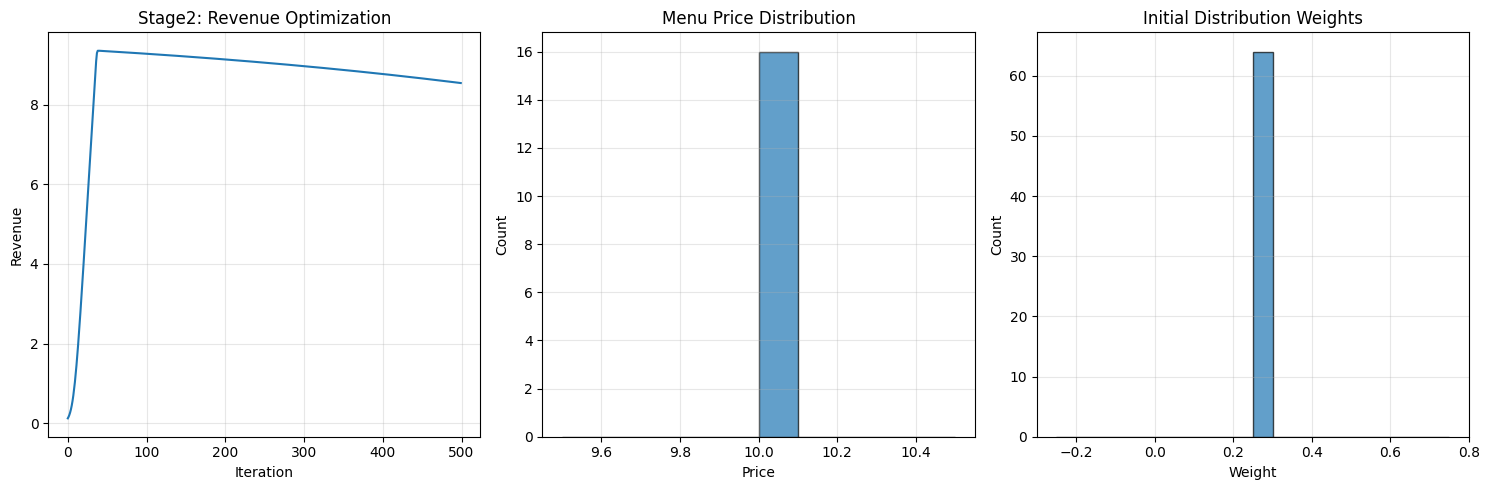

価格の統計: min=10.0000, max=10.0000, mean=10.0000


In [12]:
# Stage2の結果可視化
plt.figure(figsize=(15, 5))

# 収益の推移
plt.subplot(1, 3, 1)
plt.plot(revenues)
plt.title('Stage2: Revenue Optimization')
plt.xlabel('Iteration')
plt.ylabel('Revenue')
plt.grid(True, alpha=0.3)

# 価格の分布
plt.subplot(1, 3, 2)
prices = [elem.price().detach().item() for elem in menu[:-1]]  # null要素を除く
plt.hist(prices, bins=10, alpha=0.7, edgecolor='black')
plt.title('Menu Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# メニュー要素の重み分布
plt.subplot(1, 3, 3)
weights = [elem.weights.detach().cpu().numpy() for elem in menu[:-1]]
weights_flat = np.concatenate(weights)
plt.hist(weights_flat, bins=20, alpha=0.7, edgecolor='black')
plt.title('Initial Distribution Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"価格の統計: min={min(prices):.4f}, max={max(prices):.4f}, mean={np.mean(prices):.4f}")


In [ ]:
# メニューの詳細分析
from bundleflow.models.menu import visualize_menu

# メニューの可視化
t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)
visualize_menu(flow, menu, t_grid, max_items=8, device=device)

# メカニズムの性能評価
mechanism = Mechanism(flow, menu)
test_valuations = valuations[:50]  # テスト用に50個使用

# 期待収入の計算
expected_revenue = mechanism.expected_revenue(test_valuations)
print(f"\\n📊 性能評価:")
print(f"期待収入: {expected_revenue.detach().item():.4f}")

# ハード割当での結果
result = mechanism.argmax_menu(test_valuations)
print(f"ハード割当収入: {result['revenue'].detach().item():.4f}")
print(f"平均効用: {result['welfare'].detach().item():.4f}")
print(f"IR制約満足率: {result['ir_satisfied'].detach().item():.4f}")


In [ ]:
# 🚀 GPU使用量を最大化する設定
print("=== GPU使用量最大化設定 ===")

# 大規模設定（GPU使用量最大化）
stage2_config_large = {
    'K': 128,          # メニュー要素数を大幅増加
    'D': 16,           # 混合成分数を大幅増加
    'iters': 500,      # イテレーション数を削減（テスト用）
    'batch': 2048,     # バッチサイズを大幅増加
    'lr': 1e-2,        # 学習率
    'lam_start': 0.1,
    'lam_end': 0.5,
    'ode_steps': 100,  # ODEステップ数を大幅増加
    'n_val': 2000,     # 評価関数数を大幅増加
    'a': 256,          # XOR原子数を大幅増加
    'seed': 42
}

print("GPU使用量最大化設定:")
for key, value in stage2_config_large.items():
    print(f"  {key}: {value}")

# 新しいメニューの作成（大規模）
menu_large = [MenuElement(m=stage1_config['m'], D=stage2_config_large['D']) for _ in range(stage2_config_large['K'])]
menu_large.append(make_null_element(stage1_config['m']))

# デバイスに移動
for elem in menu_large:
    elem.to(device)

# 新しいオプティマイザー
all_params_large = []
for elem in menu_large:
    all_params_large.extend(elem.parameters())
optimizer_large = optim.Adam(all_params_large, lr=stage2_config_large['lr'])

print(f"\n🚀 大規模Stage2学習開始")
print(f"メニュー要素数: {len(menu_large)}")
print(f"学習パラメータ数: {sum(p.numel() for p in all_params_large):,}")

# GPU使用量の事前確認
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # メモリクリア
    print(f"学習開始前のGPU使用量: {torch.cuda.memory_allocated() / 1024**2:.0f}MB")

# 学習ループ（大規模版）
revenues_large = []
start_time = time.time()

for it in range(1, stage2_config_large['iters'] + 1):
    # バッチデータの準備
    batch_size = min(stage2_config_large['batch'], len(valuations))
    batch_vals = random.sample(valuations, batch_size)
    
    # 温度スケジューリング
    lam = stage2_config_large['lam_start'] + (stage2_config_large['lam_end'] - stage2_config_large['lam_start']) * (it / stage2_config_large['iters'])
    
    # 時間グリッド
    t_grid = torch.linspace(0.0, 1.0, steps=stage2_config_large['ode_steps'], device=device)
    
    # 収益損失の計算
    loss = revenue_loss(flow, batch_vals, menu_large, t_grid, lam=lam)
    
    # 最適化
    optimizer_large.zero_grad(set_to_none=True)
    loss.backward()
    optimizer_large.step()
    
    # 収益の記録
    revenues_large.append(-loss.detach().item())
    
    # 進捗表示（5イテレーションごと）
    if it % 5 == 0:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            mem_alloc = torch.cuda.memory_allocated() / 1024**2
            mem_reserved = torch.cuda.memory_reserved() / 1024**2
            mem_str = f" | GPU mem: {mem_alloc:.0f}/{mem_reserved:.0f}MB"
        else:
            mem_str = ""
        elapsed = time.time() - start_time
        print(f"[{it}/{stage2_config_large['iters']}] Revenue: {revenues_large[-1]:.6f} λ:{lam:.4f} Time:{elapsed:.1f}s{mem_str}", flush=True)

print(f"✅ 大規模Stage2学習完了! 最終収益: {revenues_large[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")

# 最終GPU使用状況
if torch.cuda.is_available():
    torch.cuda.synchronize()
    mem_alloc = torch.cuda.memory_allocated() / 1024**2
    mem_reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"🔍 Final GPU memory usage: {mem_alloc:.0f}MB allocated, {mem_reserved:.0f}MB reserved")


In [ ]:
# 生成される束の分析
plt.figure(figsize=(12, 4))

# 各メニュー要素から生成される束の分析
bundle_sizes = []
bundle_diversities = []

with torch.no_grad():
    for i, elem in enumerate(menu[:5]):  # 最初の5要素を分析
        # 束生成
        s_T = flow.flow_forward(elem.mus, t_grid)
        bundles = flow.round_to_bundle(s_T)
        
        # 束サイズの分布
        sizes = bundles.sum(dim=1).detach().cpu().numpy()
        bundle_sizes.extend(sizes)
        
        # 多様性
        unique_bundles = torch.unique(bundles, dim=0)
        diversity = len(unique_bundles) / bundles.shape[0]
        bundle_diversities.append(diversity)

# 束サイズの分布
plt.subplot(1, 2, 1)
plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
plt.title('Bundle Size Distribution\\n(All Menu Elements)')
plt.xlabel('Bundle Size')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# 多様性の分布
plt.subplot(1, 2, 2)
plt.bar(range(len(bundle_diversities)), bundle_diversities, alpha=0.7, edgecolor='black')
plt.title('Bundle Diversity per Menu Element')
plt.xlabel('Menu Element Index')
plt.ylabel('Diversity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"束サイズの統計: min={min(bundle_sizes)}, max={max(bundle_sizes)}, mean={np.mean(bundle_sizes):.1f}")
print(f"多様性の統計: min={min(bundle_diversities):.3f}, max={max(bundle_diversities):.3f}, mean={np.mean(bundle_diversities):.3f}")


## 🎉 まとめ

このデモンストレーションでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化を実行しました。

### 実行した内容
1. **環境セットアップ**: GPU環境の確認とパッケージインストール
2. **新しいAPI構造のデモ**: BundleFlow、MenuElement、XORValuationの基本機能
3. **Stage1学習**: 速度場ネットワークの学習（連続→離散変換）
4. **Stage2学習**: メニュー要素の最適化（価格と初期分布）
5. **結果可視化**: 学習結果とメニュー性能の分析

### 新しいAPI構造の利点
- **明確な責務分離**: 速度場、メニュー要素、評価関数が独立
- **型安全性**: 完全な型注釈とdocstring
- **経済学的記号**: 論文と一致した記号体系
- **後方互換性**: 既存コードも動作

### 次のステップ
- より大きな問題サイズでの実験
- 異なる評価関数分布での性能比較
- ハイパーパラメータの最適化
- 実際のオークションデータでの検証

---

**📚 詳細な情報**: [MODEL.md](MODEL.md) - モデル記号と目的のドキュメント
